<h1 align="center">🚕</h1>
<h1 align="center">Predicting the Taxi Fare of New York City riders using Machine Learning</h1>

<hr/>
<div align="center">In this notebook, the goal is to predict the New York City Taxi Fare.</div>

## The big picture.

### 1. Problem

> How well can we predict the fare amount for a taxi ride in New York City, given the pickup and dropoff locations ?

### 2. Data

The data is downloaded from the Kaggle New York City Taxi Fare Prediction competition:
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data

There are two main datasets:
- **Train.csv**, the training set, which contains data from January 1, 2009 - June 30, 2015.
- **Test.csv**, the test set, which contains data from January 1, 2009 - June 30, 2015.

### 3. Evaluation

The evaluation metric for this competition is the **RMSE (Root Mean-Squared Error)** between the actual and predicted fare amount.

For more on the evaluation on this project check:
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview/evaluation

### 4. Features

* **pickup_datetime** - timestamp value indicating when the taxi ride started.
* **pickup_longitude** - float for longitude coordinate of where the taxi ride started.
* **pickup_latitude** - float for latitude coordinate of where the taxi ride started.
* **dropoff_longitude** - float for longitude coordinate of where the taxi ride ended.
* **dropoff_latitude** - float for latitude coordinate of where the taxi ride ended.
* **passenger_count** - integer indicating the number of passengers in the taxi ride.
* **fare_amount** - float dollar amount of the cost of the taxi ride.

### 5. Frame the problem

It is clearly a typical **supervised learning task**, since we are given a target attribute `fare_amount`.

It is also a typical **regression task**, since we aimed to predict a value, the amount of the cost of the taxi ride.

More specifically, it is a **multiple regression problem**, since the system will use multiple features to make a prediction, and a **univariate regression problem**, since we are only trying to predict a single value for each taxi ride.

Finally, there is no continuous flow of data coming into the system, there is no particular need to adjust to changing data rapidly, and the data is small enough to fit in memory, so **plain batch learning** should do just fine.

<hr/>

In [56]:
# Standard imports

# Regular EDA and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline

# Transformation libraries
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Models from Scikit-Learn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Model Evaluations
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

## Get the Data.

In [2]:
# Load the training set
NB_ROWS = 20000 # we are sampling the data down to a manageable size which is good to get started
taxi_original = pd.read_csv("datasets/new-york-city-taxi/train.csv", nrows=NB_ROWS)

#/?\ I could create here a function to fetch the data
#/!\ I also need to shuffle the data when I sample it down (see page 52 end + 53), avoid the sampling bias, make sure that the 20000 instances are representative? or test set?

In [3]:
# Load the test set
taxi_test = pd.read_csv("datasets/new-york-city-taxi/test.csv")

In [4]:
taxi_original.shape, taxi_test.shape

((20000, 8), (9914, 7))

In [5]:
# Further in the notebook, we have to make sure that the test set is representative of the whole taxi rides. (page 54)
# or like in page 56, we can process the strat_.. here in order to have a sample (20000) representative of the test set we are given ?

## EDA.

We will here try to find out more about the data.

#### Copy of the original DataFrame for exploration
We make a copy of the original DataFrame so when we manipulate the copy, we've still got our original data.

In [6]:
taxi = taxi_original.copy()

In [7]:
taxi["fare_amount"].value_counts()

6.50     951
4.50     834
8.50     774
5.30     574
6.10     565
        ... 
37.53      1
41.04      1
59.10      1
22.54      1
28.54      1
Name: fare_amount, Length: 483, dtype: int64

In [8]:
taxi.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [9]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                20000 non-null  object 
 1   fare_amount        20000 non-null  float64
 2   pickup_datetime    20000 non-null  object 
 3   pickup_longitude   20000 non-null  float64
 4   pickup_latitude    20000 non-null  float64
 5   dropoff_longitude  20000 non-null  float64
 6   dropoff_latitude   20000 non-null  float64
 7   passenger_count    20000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 1.2+ MB


In [10]:
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,11.303321,-72.478584,39.921043,-72.497221,39.913606,1.658000
std,9.541637,10.525376,6.678592,10.460530,6.139231,1.283674
min,-3.000000,-74.438233,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992150,40.734706,-73.991224,40.734537,1.000000
50%,8.500000,-73.981711,40.752680,-73.980216,40.753583,1.000000
75%,12.500000,-73.966802,40.767443,-73.963729,40.768135,2.000000
max,180.000000,40.766125,401.083332,40.802437,41.366138,6.000000


In [11]:
# % of missing values
taxi.isna().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

Each row represents one race. There are 7 attributes: `key`, `pickup_datetime`, `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude` and `passenger_count`.

All attributes are numerical except the `key` and the `pickup_datetime` fields. For `pickup_datetime`, its type is object, but we know that it must be a date attribute. `key` is the combination of `pickup_datetime` and an id.

There are 20,000 instances in the dataset. Notice that none of the attributes contain null values.

#### Visualizing the Data

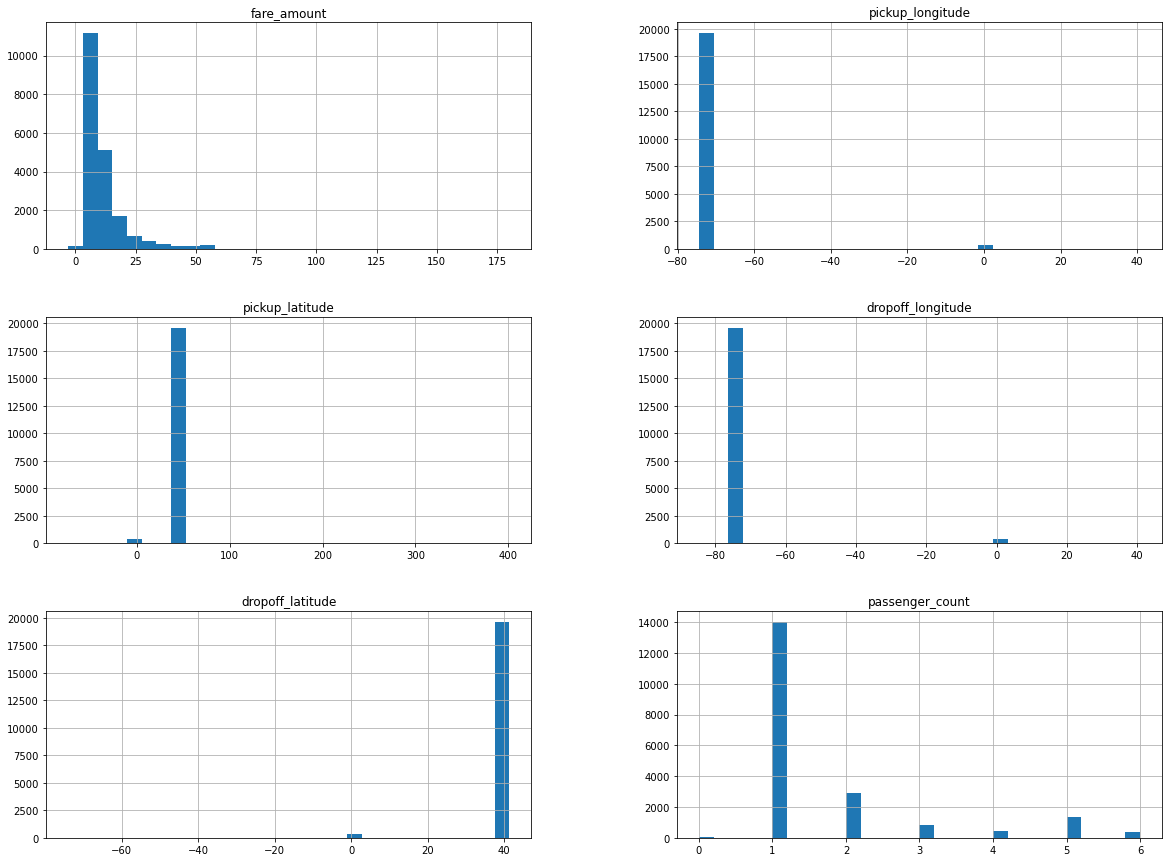

In [12]:
taxi.hist(bins=30, figsize=(20,15))
plt.show()

We notice that some attributes have a tail-heavy distribution. It seems maybe that long/lat have outliers.

In [13]:
#Corriger plus tard ces outliers dans la section Prepare the Data

In [14]:
# Let's see the pickup_datetime attribute and plot it with the fare_amount value
taxi.pickup_datetime[:10]

0    2009-06-15 17:26:21 UTC
1    2010-01-05 16:52:16 UTC
2    2011-08-18 00:35:00 UTC
3    2012-04-21 04:30:42 UTC
4    2010-03-09 07:51:00 UTC
5    2011-01-06 09:50:45 UTC
6    2012-11-20 20:35:00 UTC
7    2012-01-04 17:22:00 UTC
8    2012-12-03 13:10:00 UTC
9    2009-09-02 01:11:00 UTC
Name: pickup_datetime, dtype: object

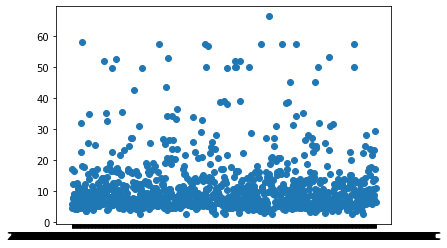

In [15]:
fig, ax = plt.subplots()
ax.scatter(taxi["pickup_datetime"][:1000], taxi["fare_amount"][:1000]);

In [16]:
taxi.passenger_count.value_counts()

1    13999
2     2912
5     1327
3      860
4      420
6      407
0       75
Name: passenger_count, dtype: int64

In [17]:
# Should we delete data instances with no passengers?

#### Visualizing Geographical Data

Since there is geographical information (`latitud`, `longitude`), it is a good idea to plot the data of all taxi rides.

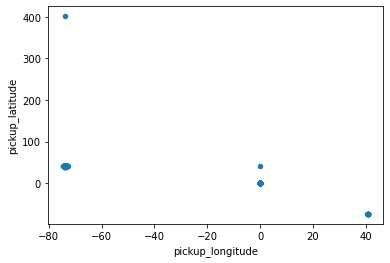

In [18]:
taxi.plot(kind="scatter", x="pickup_longitude", y="pickup_latitude");

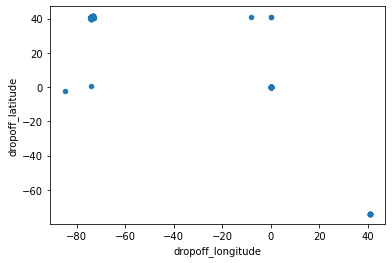

In [19]:
taxi.plot(kind="scatter", x="dropoff_longitude", y="dropoff_latitude");

#### Looking for Correlations

Now let's look at how much each attribute correlates with the fare amount value.

In [20]:
corr_matrix = taxi.corr()
corr_matrix

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
fare_amount,1.000000,0.013226,-0.015276,0.013114,-0.014112,0.010379
pickup_longitude,0.013226,1.000000,-0.907930,0.961721,-0.947875,-0.008849
pickup_latitude,-0.015276,-0.907930,1.000000,-0.877113,0.894926,0.006015
dropoff_longitude,0.013114,0.961721,-0.877113,1.000000,-0.977122,-0.007974
dropoff_latitude,-0.014112,-0.947875,0.894926,-0.977122,1.000000,0.006698
passenger_count,0.010379,-0.008849,0.006015,-0.007974,0.006698,1.000000


In [21]:
corr_matrix["fare_amount"].sort_values(ascending=False)

fare_amount          1.000000
pickup_longitude     0.013226
dropoff_longitude    0.013114
passenger_count      0.010379
dropoff_latitude    -0.014112
pickup_latitude     -0.015276
Name: fare_amount, dtype: float64

Coefficients close to 0 mean that there is no linear correlation.

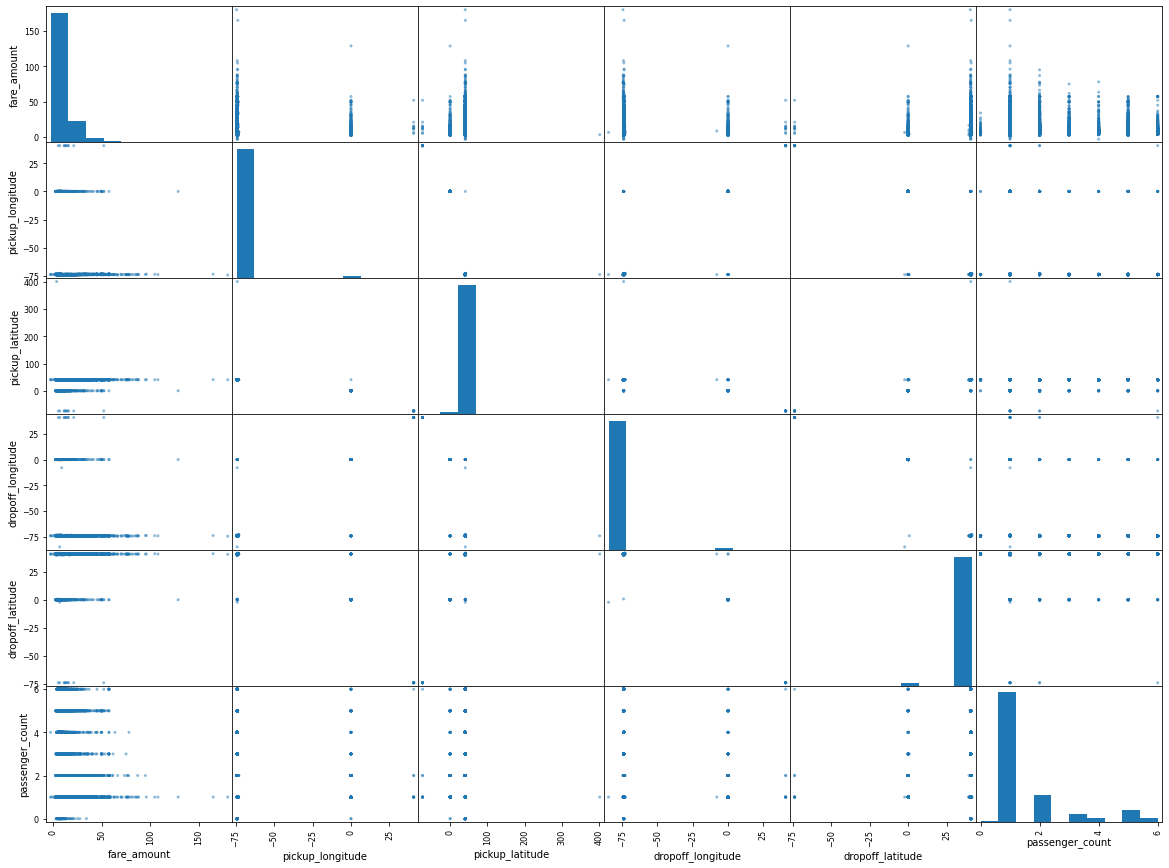

In [22]:
from pandas.plotting import scatter_matrix
attributes = ["fare_amount", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude", "passenger_count"]
scatter_matrix(taxi[attributes], figsize=(20, 15))
plt.show()

In [23]:
# peut être enlever ce dernier graph

#### Let's try some various attribute combinations

#### Parsing dates

As we are working with time series data, we want to enrich the time and date component as much as possible.

In [24]:
# We import the data again but we parse dates
taxi = pd.read_csv("datasets/new-york-city-taxi/train.csv", nrows=NB_ROWS,
                  low_memory=False,
                  parse_dates=["pickup_datetime"])
taxi.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [25]:
taxi.pickup_datetime.dtype

datetime64[ns, UTC]

In [26]:
taxi.pickup_datetime[:10]

0   2009-06-15 17:26:21+00:00
1   2010-01-05 16:52:16+00:00
2   2011-08-18 00:35:00+00:00
3   2012-04-21 04:30:42+00:00
4   2010-03-09 07:51:00+00:00
5   2011-01-06 09:50:45+00:00
6   2012-11-20 20:35:00+00:00
7   2012-01-04 17:22:00+00:00
8   2012-12-03 13:10:00+00:00
9   2009-09-02 01:11:00+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]

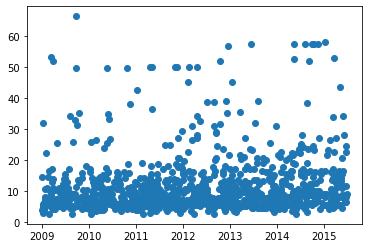

In [27]:
fig, ax = plt.subplots()
ax.scatter(taxi["pickup_datetime"][:1000], taxi["fare_amount"][:1000]);

In [28]:
# Sort DataFrame in date order
taxi.sort_values(by=["pickup_datetime"], inplace=True, ascending=True)
taxi.pickup_datetime.head(10)

12739   2009-01-01 01:31:49+00:00
17546   2009-01-01 02:05:37+00:00
8684    2009-01-01 02:51:52+00:00
11623   2009-01-01 15:19:00+00:00
10004   2009-01-01 16:52:00+00:00
7756    2009-01-01 17:07:00+00:00
13904   2009-01-01 19:57:19+00:00
16313   2009-01-01 22:40:03+00:00
2354    2009-01-02 02:32:41+00:00
7704    2009-01-02 06:35:00+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]

In [29]:
# Add datetime parameters for pickup_datetime column
taxi["pickupYear"] = taxi.pickup_datetime.dt.year
taxi["pickupMonth"] = taxi.pickup_datetime.dt.month
taxi["pickupDay"] = taxi.pickup_datetime.dt.day
taxi["pickupDayOfWeek"] = taxi.pickup_datetime.dt.dayofweek
taxi["pickupDayOfYear"] = taxi.pickup_datetime.dt.dayofyear

In [30]:
taxi.head().T

,12739,17546,8684,11623,10004
key,2009-01-01 01:31:49.0000003,2009-01-01 02:05:37.0000004,2009-01-01 02:51:52.0000002,2009-01-01 15:19:00.000000146,2009-01-01 16:52:00.00000053
fare_amount,8.600000,11.000000,10.200000,5.300000,8.500000
pickup_datetime,2009-01-01 01:31:49+00:00,2009-01-01 02:05:37+00:00,2009-01-01 02:51:52+00:00,2009-01-01 15:19:00+00:00,2009-01-01 16:52:00+00:00
pickup_longitude,-73.994192,-73.978433,-73.956172,-73.949937,-73.967647
pickup_latitude,40.720077,40.744781,40.771965,40.784427,40.763077
dropoff_longitude,-73.993356,-74.004713,-73.991027,-73.948735,-73.977438
dropoff_latitude,40.742642,40.734328,40.751035,40.773738,40.787097
passenger_count,1,1,2,5,2
pickupYear,2009,2009,2009,2009,2009
pickupMonth,1,1,1,1,1


In [31]:
# We don't need the pickup_datetime attribute anymore
taxi.drop("pickup_datetime", axis=1, inplace=True)

#### Conclusion EDA

We have noticed few things about the data so we are going to clean up before feeding the data to a Machine Learning algorithm.

## Prepare the Data.

In [32]:
# Let's separate the predictors and the labels
taxi_train = taxi.drop("fare_amount", axis=1)
taxi_labels = taxi["fare_amount"].copy()

In [33]:
taxi_train.head()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickupYear,pickupMonth,pickupDay,pickupDayOfWeek,pickupDayOfYear
12739,2009-01-01 01:31:49.0000003,-73.994192,40.720077,-73.993356,40.742642,1,2009,1,1,3,1
17546,2009-01-01 02:05:37.0000004,-73.978433,40.744781,-74.004713,40.734328,1,2009,1,1,3,1
8684,2009-01-01 02:51:52.0000002,-73.956172,40.771965,-73.991027,40.751035,2,2009,1,1,3,1
11623,2009-01-01 15:19:00.000000146,-73.949937,40.784427,-73.948735,40.773738,5,2009,1,1,3,1
10004,2009-01-01 16:52:00.00000053,-73.967647,40.763077,-73.977438,40.787097,2,2009,1,1,3,1


In [34]:
taxi_train.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickupYear,pickupMonth,pickupDay,pickupDayOfWeek,pickupDayOfYear
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000
mean,-72.478584,39.921043,-72.497221,39.913606,1.658000,2011.750050,6.244350,15.67785,3.037000,174.514600
std,10.525376,6.678592,10.460530,6.139231,1.283674,1.863343,3.445335,8.67658,1.964516,105.092987
min,-74.438233,-74.006893,-84.654241,-74.006377,0.000000,2009.000000,1.000000,1.00000,0.000000,1.000000
25%,-73.992150,40.734706,-73.991224,40.734537,1.000000,2010.000000,3.000000,8.00000,1.000000,84.000000
50%,-73.981711,40.752680,-73.980216,40.753583,1.000000,2012.000000,6.000000,16.00000,3.000000,166.000000
75%,-73.966802,40.767443,-73.963729,40.768135,2.000000,2013.000000,9.000000,23.00000,5.000000,267.000000
max,40.766125,401.083332,40.802437,41.366138,6.000000,2015.000000,12.000000,31.00000,6.000000,366.000000


In [35]:
taxi_train.dtypes

key                   object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
pickupYear             int64
pickupMonth            int64
pickupDay              int64
pickupDayOfWeek        int64
pickupDayOfYear        int64
dtype: object

In [37]:
taxi_labels.head()

12739     8.6
17546    11.0
8684     10.2
11623     5.3
10004     8.5
Name: fare_amount, dtype: float64

In [38]:
taxi_train["key"].head()

12739      2009-01-01 01:31:49.0000003
17546      2009-01-01 02:05:37.0000004
8684       2009-01-01 02:51:52.0000002
11623    2009-01-01 15:19:00.000000146
10004     2009-01-01 16:52:00.00000053
Name: key, dtype: object

### Data Cleaning, Feature Engineering and Feature Scaling

#### Handling Attributes with Missing Values
As we are not sure that our whole dataset doesn't contain missing values, we will apply the imputer (a Scikit-Learn handy class) to all the numerical attributes. For doing this, we will use the transformer named `SimpleImputer`.


#### Handling Text and Categorical Attributes
In this project, we don't have categorical attributes.
Still, we have to handle the text attribute that is `key`.

We could handle this text attribute by using a regex to split datetime and the id separated by a ".", but we consider that we will not use this id and we already have the datetime information in other attributes.


#### Standardize numerical features
ML algorithms don't perform well when the input numerical attributes have very different scales.

This is the case for the taxi data: the `pickup_longitude` ranges from about -74 to 40.767, while the `passenger_count` ranges from 0 to 6.

#### Transformation Pipeline

We create a Pipeline so we will be able to apply the transformations to our whole dataset (including the test set) and to new fresh dataset.


In [39]:
# Check which columns are numerical and which one are non numerical
def get_num_col(df):
    """
    Given a dataset, it returns a list of the columns that are numerical.
    """
    
    num_col = []
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            num_col.append(label)
    return num_col

num_attribs = get_num_col(taxi_train)
num_attribs

['pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count',
 'pickupYear',
 'pickupMonth',
 'pickupDay',
 'pickupDayOfWeek',
 'pickupDayOfYear']

In [40]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])


full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("key_att", "drop", ["key"])
])

taxi_train_prepared = full_pipeline.fit_transform(taxi_train)

In [41]:
# Drop the `key` attribute
#taxi_train.drop("key", axis=1, inplace=True)

In [42]:
#taxi_train = pd.DataFrame(taxi_train_prepared, columns=taxi_train.columns, index=taxi_train.index)

In [43]:
#taxi_train.head()

In [44]:
#taxi_train.dtypes

In [45]:
#taxi_train.describe()

#### Fix or remove outliers

Here we don't need to handle this step because we have used the StandardScaler and this standardization is not affected by outliers.

If we think that it may affect our estimation, we may want to fix outliers.

We've done some EDA and preprocessing on our data. Now let's start to do some model-driven EDA.

## Select and Train a Model.

### Training and Evaluating on the Training Set

In [46]:
lin_reg = LinearRegression()
lin_reg.fit(taxi_train_prepared, taxi_labels)

LinearRegression()

Now that we have a working Linear Regression model, let's try it out on a few instances from the training set.

In [47]:
some_data = taxi_train.iloc[:5]
some_labels = taxi_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [8.83818612 8.83780784 8.90394054 9.10457808 8.90343936]
Labels: [8.6, 11.0, 10.2, 5.3, 8.5]


In [48]:
taxi_preds = lin_reg.predict(taxi_train_prepared)
lin_mse = mean_squared_error(taxi_labels, taxi_preds)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

9.465258686830639

In [49]:
lin_reg.score(taxi_train_prepared, taxi_labels)

0.015896203581442725

This is not a very good score, let's try with a Random Forest Regression model.

In [51]:
rd_reg = RandomForestRegressor(n_jobs=1,
                             random_state=42)
rd_reg.fit(taxi_train_prepared, taxi_labels)

RandomForestRegressor(n_jobs=1, random_state=42)

In [52]:
print("Predictions:", rd_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [ 8.792 10.123 11.036  5.214  8.256]
Labels: [8.6, 11.0, 10.2, 5.3, 8.5]


In [54]:
taxi_preds = rd_reg.predict(taxi_train_prepared)
rd_mse = mean_squared_error(taxi_labels, taxi_preds)
rd_rmse = np.sqrt(rd_mse)
rd_rmse

1.7999813009992358

In [55]:
rd_reg.score(taxi_train_prepared, taxi_labels)

0.9644113168478252

This result is way more better than the first one, but how can we be sure that this model is very good ?

### Better Evaluation Using Cross-Validation

One way to evaluate the Random Forest Regression model would be to use the train_test_split() function to split the training set into a smaller training set and a validation set.

Here we will use the Scikit-Learn's **K-fold cross-validation** feature.

In [57]:
scores = cross_val_score(rd_reg, taxi_train_prepared, taxi_labels,
                        scoring="neg_mean_squared_error", cv=10)
rd_rmse_scores = np.sqrt(-scores)

In [58]:
# Create function to evaluate model on a few different levels

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation", scores.std())
    
display_scores(rd_rmse_scores)

Scores: [4.93059435 4.64672716 5.62165436 3.51557174 5.26611154 4.50697569
 5.69201895 3.8669315  5.60678144 4.71677038]
Mean: 4.837013712164774
Standard deviation 0.7056189085250095


Let's compute the same scores for the Linear Regression model just to be sure.

In [59]:
lin_scores = cross_val_score(lin_reg, taxi_train_prepared, taxi_labels,
                        scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [60]:
display_scores(lin_rmse_scores)

Scores: [ 8.44409326  8.41005001  8.70225606  7.68353457  9.23639974  9.6932067
 10.53314879  9.8544775  11.01869018 10.61641849]
Mean: 9.419227529456602
Standard deviation 1.0500621358530147


As we can see, our Random Forest Regressor model is performing much better on the training set, meaning that the model is overfitting the training set.

Possible solutions for overfitting are:
* To simplify the model
* Constrain it
* Or get a lot more training data

#### Let's try some other models to get a few (two to five) promising models before diving much deeper into the Fine-Tune Step.